# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

# Init

In [223]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [224]:
%%R
library(foreach)
library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


In [225]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

## Set file locations

In [226]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  tables table 

In [227]:
%%R
setwd(workDir)
# read phylogenetic distance, expanded with 0.0002 between maize
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)
colnames(phy_expand)[12] = "75-062"

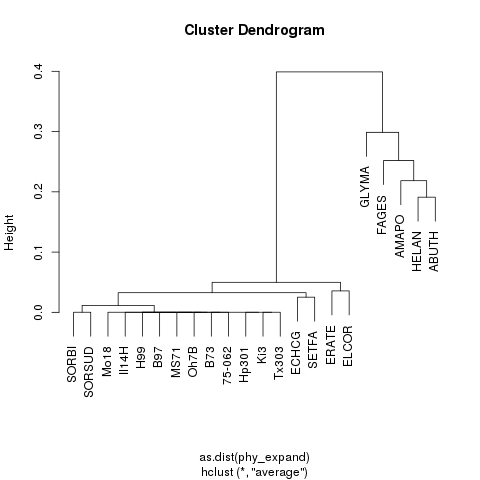

In [228]:
%%R
Phy_hc = hclust(as.dist(phy_expand), "average")
plot(Phy_hc)

In [229]:
%%R 

NAMdist = read.table(NAMFile, header = TRUE)
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

In [230]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")
physeq.Nneg = filter_taxa(physeq.Nneg, function(x) sum(x > 0) > 0, TRUE)  
physeq.Nneg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


In [231]:
%%R
sample_data(physeq.Full) %>% filter(Plant != "BARE") %>% .$InorganicN 

  [1]  8.278627  8.125213  7.918973  8.963165 12.768339  6.847902 13.588167
  [8]  6.369843  7.188708  7.051508  6.183494  7.270668  8.397916        NA
 [15]        NA 15.391546  6.423144  7.140380  6.207876 13.193849  6.168921
 [22]        NA  5.173537 13.465720  4.009799  5.626327 16.899191  8.500441
 [29]  5.373262  8.408844  5.902186        NA  6.634164  5.635889        NA
 [36]  5.854355  8.114796  5.052936  7.773524  3.664889        NA        NA
 [43] 15.644427  7.872537  4.744561  6.239278 25.442993        NA        NA
 [50]        NA        NA 20.211667 15.543360  4.895955  4.422297  5.473452
 [57]        NA 35.021310        NA        NA  5.844123  7.359647        NA
 [64]        NA  4.480212        NA  9.445399        NA        NA  4.131688
 [71]        NA  6.155739  5.732947        NA        NA 24.070209  9.505402
 [78]        NA 11.859845 15.747796  5.789485 18.652602  6.156955        NA
 [85] 14.443566 12.264973  6.009090  8.154514  5.970404        NA 10.332289
 [92] 14.522

## Define subset of plants for model comparison

In [397]:
%%R
# phy = subset_samples(physeq.Nneg, Plant %in% c("AMAPO", "GLYMA",  "ERATE", 
#  "ELCOR",  "SORSUD",    "SORBI",  "ABUTH",  "HELAN",  "ECHCG", "SETFA", "MS71", "Mo18"))

phy = physeq.Nneg

phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4927 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4927 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4927 tips and 4926 internal nodes ]


## Calculate w-Unifrac distances

In [233]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

## Create melted dataframes for plot by plot comparisons

In [234]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m %>% head


  PlantA PlantB phy_Dist   PlantComp
1  FAGES  FAGES  0.00000 FAGES-FAGES
2  AMAPO  FAGES  0.23210 AMAPO-FAGES
3  HELAN  FAGES  0.25302 HELAN-FAGES
4  ABUTH  FAGES  0.27096 ABUTH-FAGES
5  GLYMA  FAGES  0.35879 GLYMA-FAGES
6  SORBI  FAGES  0.43476 SORBI-FAGES


In [235]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
88  sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072
175 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861
176 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471
262 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018
263 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794
264 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279
[1] 3741    3


## Create functional distance variable (with residuals)

In [236]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
    Plant SeedSize_mg
1   ERATE      0.0035
2   HELAN     90.0000
3     B73    333.0000
4   FAGES     38.0000
5   AMAPO      0.4900
6  SORSUD     10.7000
7   SORBI     32.3900
8   ELCOR      3.2000
9   ECHCG      1.5800
10  ABUTH      9.6000
11  SETFA      1.8000
12  GLYMA    174.0000
13   MS71      0.2640
14   Mo18      0.2240
15  Il14H      0.2190
16  Tx303      0.2790
17   Oh7B      0.2070
18    B97      0.2400
19  Hp301      0.0869
20 75-062      0.2220
21    Ki3      0.2280
22    H99      0.2310


In [237]:
%%R
head(sd)

           X.sample Library Primer_Plate Primer_Well_ID primerFR_ID_byPlate
1 sample5-1.22_Nneg       1            1             A4                  25
2 sample4-2.02_Nneg       1            1             C3                  19
3 sample4-4.21_Nneg       1            1             G3                  23
4 sample5-2.29_Nneg       1            1             C4                  27
5 sample5-2.06_Nneg       1            2             C1                   3
6 sample1-2.23_Nneg       1            1             C1                   3
  primerFR_ID_total barcode_ID    PlotID  Plant Plot Treatment Rep DAP Sampling
1                25         25 1.22_Nneg 75-062 1.22      Nneg   1  72  sample5
2                19         19 2.02_Nneg  SETFA 2.02      Nneg   2  61  sample4
3                23         23 4.21_Nneg  SETFA 4.21      Nneg   4  61  sample4
4                27         27 2.29_Nneg 75-062 2.29      Nneg   2  72  sample5
5                99         99 2.06_Nneg   MS71 2.06      Nneg   2  

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                         PC1    PC2    PC3     PC4
Standard deviation     1.527 1.0247 0.7848 0.04564
Proportion of Variance 0.583 0.2625 0.1540 0.00052
Cumulative Proportion  0.583 0.8455 0.9995 1.00000
                        PC1        PC2        PC3          PC4
log(SeedSize_mg)  0.4375562 -0.3576541 -0.8249996 -0.001934066
A_Resid_logN      0.6312646  0.1535568  0.2699008 -0.710689000
A_Resid_logCN    -0.2778570 -0.8660244  0.2288852 -0.346999792
A_Resid_logB      0.5769273 -0.3138561  0.4406140  0.611971036


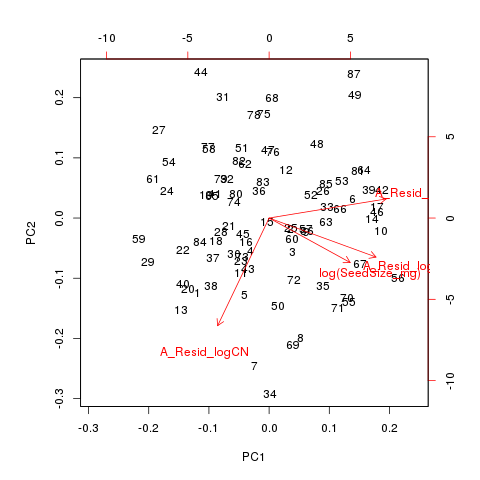

In [238]:
%%R
# PCA of annuals
sd = as(sample_data(phy), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")

 fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

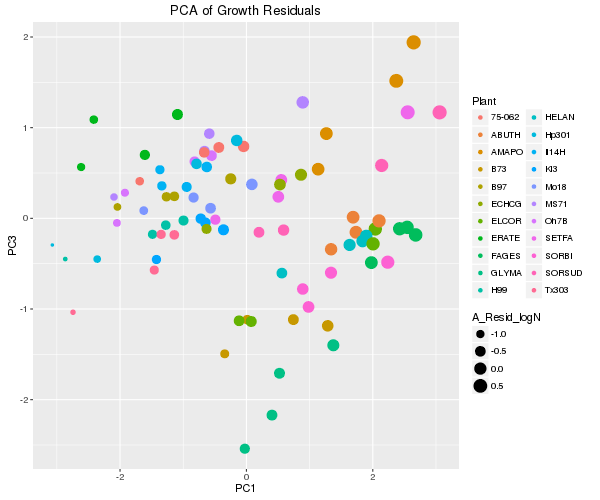

In [239]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

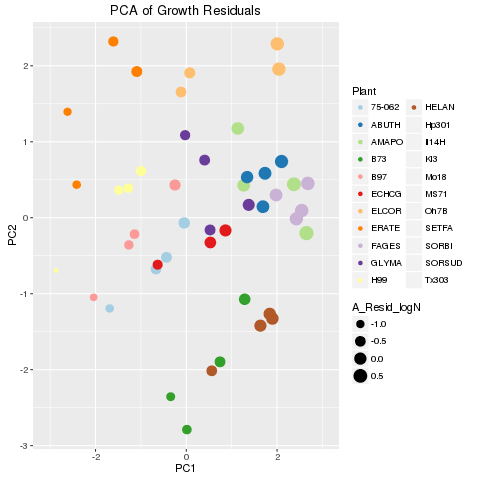

In [240]:
%%R
p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [241]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB    PC3Dist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.00000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.17182051
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.01426713
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.37236147
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.52468978
6 sample1-2.23_Nneg sample5-1.22_Nneg 0.89750562
                             PlotComp
1 sample5-1.22_Nneg-sample5-1.22_Nneg
2 sample4-2.02_Nneg-sample5-1.22_Nneg
3 sample4-4.21_Nneg-sample5-1.22_Nneg
4 sample5-2.29_Nneg-sample5-1.22_Nneg
5 sample5-2.06_Nneg-sample5-1.22_Nneg
6 sample1-2.23_Nneg-sample5-1.22_Nneg
              PlotA             PlotB     CNdist
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.00000000
2 sample4-2.02_Nneg sample5-1.22_Nneg 0.39380360
3 sample4-4.21_Nneg sample5-1.22_Nneg 0.30193239
4 sample5-2.29_Nneg sample5-1.22_Nneg 0.21610061
5 sample5-2.06_Nneg sample5-1.22_Nneg 0.03917953
6 sample1-2.23_Nneg sample5-1.22_Nneg 0.66441421
                             PlotComp
1 sample5-

## Join distance tables

In [242]:
%%R
#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot comparison for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA
              PlotA             PlotB w_Unif_Dist PlantA  Plant
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA
2 sample5-1.22_Nneg sample4-4.21_Nneg   0.1605861 75-062  SETFA
3 sample4-2.02_Nneg sample4-4.21_Nneg   0.1853471  SETFA  SETFA
4 sample5-1.22_Nneg sample5-2.29_Nneg   0.1505018 75-062 75-062
5 sample4-2.02_Nneg sample5-2.29_Nneg   0.1881794  SETFA 75-062
6 sample4-4.21_Nneg sample5-2.29_Nneg   0.1816279  SETFA 75-062
              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample4-2.02_Nneg   0.2069072 75-062  SETFA  75-062-SET

## Join with plant phylogenetic distance and functional distance

In [243]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9:10] = c("LibraryA","DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[11:12] = c("LibraryB","DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, PCA.m[,3:9], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$DAY_A = as.factor(Dist$DAY_A)
Dist$DAY_B = as.factor(Dist$DAY_B)
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

#create factor for cross library comps and same day comps
Dist$LibraryComp = ifelse(Dist$LibraryA == Dist$LibraryB, 0, 1) %>% as.factor
Dist$SameDay = ifelse(Dist$DAY_A == Dist$DAY_B, 0, 1) %>% as.factor

head(Dist)

                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_Nneg sample8-3.03_Nneg   0.2419601  ABUTH  ELCOR ABUTH-ELCOR
3737 sample8-1.23_Nneg sample8-3.03_Nneg   0.1984166    Ki3  ELCOR   Ki3-ELCOR
3738 sample6-2.14_Nneg sample8-3.03_Nneg   0.2503097  Hp301  ELCOR Hp301-ELCOR
3739 sample8-4.04_Nneg sample8-3.03_Nneg   0.2377478   Mo18  ELCOR  Mo18-ELCOR
3740 sample3-3.30_Nneg sample8-3.03_Nneg   0.2233484  ABUTH  ELCOR ABUTH-ELCOR
3741 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR SORBI-ELCOR
                                PlotComp phy_Dist
3736 sample3-2.19_Nneg-sample8-3.03_Nneg  0.36639
3737 sample8-1.23_Nneg-sample8-3.03_Nneg  0.05090
3738 sample6-2.14_Nneg-sample8-3.03_Nneg  0.05090
3739 sample8-4.04_Nneg-sample8-3.03_Nneg  0.05090
3740 sample3-3.30_Nneg-sample8-3.03_Nneg  0.36639
3741 sample7-4.14_Nneg-sample8-3.03_Nneg  0.04779
                 PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
3736 sample3-2.19_

# Build corMLPE models

## corMLPE models without random effects

In [43]:
%%R
str(Dist)

'data.frame':	3741 obs. of  21 variables:
 $ PlotA      : chr  "sample5-1.22_Nneg" "sample5-1.22_Nneg" "sample4-2.02_Nneg" "sample5-1.22_Nneg" ...
 $ PlotB      : chr  "sample4-2.02_Nneg" "sample4-4.21_Nneg" "sample4-4.21_Nneg" "sample5-2.29_Nneg" ...
 $ w_Unif_Dist: num  0.207 0.161 0.185 0.151 0.188 ...
 $ PlantA     : chr  "75-062" "75-062" "SETFA" "75-062" ...
 $ PlantB     : chr  "SETFA" "SETFA" "SETFA" "75-062" ...
 $ PlantComp  : chr  "75-062-SETFA" "75-062-SETFA" "SETFA-SETFA" "75-062-75-062" ...
 $ PlotComp   : chr  "sample5-1.22_Nneg-sample4-2.02_Nneg" "sample5-1.22_Nneg-sample4-4.21_Nneg" "sample4-2.02_Nneg-sample4-4.21_Nneg" "sample5-1.22_Nneg-sample5-2.29_Nneg" ...
 $ phy_Dist   : num  0.0311 0.0311 0 0 0.0311 ...
 $ LibraryA   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_A      : Factor w/ 8 levels "36","53","57",..: 5 5 4 5 4 4 5 4 4 5 ...
 $ LibraryB   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_B      : Factor w/ 8 levels "36","53","57",..: 4 4 4 5 5 5 5 5 5 5 ...
 $ PC1Dist    : n

In [44]:
%%R
#Base models
fit1 =  gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
Z <- corZ(fit1) #extract correlation structure from previous fit

In [57]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: Dist 
        AIC       BIC   logLik
  -11783.89 -11765.21 5894.943

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2574348 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2503534 0.00751048 33.33388       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2180940 -0.7392044 -0.1107053  0.6166584  4.4016003 

Residual standard error: 0.06865901 
Degrees of freedom: 3741 total; 3740 residual


In [58]:
%%R
#Controlling for time and batch effects, using same correlation structure
fit2 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit2)


Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12384.39 -12347.04 6198.196

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2713269 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20907319 0.007491263 27.908937       0
TimeDist     0.00125187 0.000090928 13.767600       0
SameDay1     0.02002566 0.002488400  8.047607       0
LibraryComp1 0.01071976 0.001546897  6.929847       0

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.030              
SameDay1     -0.175 -0.480       
LibraryComp1 -0.019 -0.164 -0.192

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3629892 -0.7375196 -0.1300983  0.5913388  4.3035740 

Residual standard error: 0.06481681 
Degrees of freedom: 3741 total; 3737 residual


In [85]:
%%R
#Hypothesis testing functional distance
fit3 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1dist + PC2dist + PC3dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1dist + PC2dist +      PC3dist 
  Data: Dist 
        AIC       BIC   logLik
  -12342.55 -12286.52 6180.276

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2712083 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20919377 0.007685568 27.219037  0.0000
TimeDist      0.00125102 0.000091020 13.744368  0.0000
SameDay1      0.02007634 0.002489578  8.064154  0.0000
LibraryComp1  0.01081369 0.001551344  6.970531  0.0000
PC1dist      -0.00051599 0.000598246 -0.862500  0.3885
PC2dist       0.00010982 0.000881610  0.124573  0.9009
PC3dist       0.00067601 0.001141623  0.592148  0.5538

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1 PC1dst PC2dst
TimeDist     -0.021                                   
SameDay1     -0.171 -0.480                            
LibraryComp1 -0.027 -0.166 -0.190                     

In [86]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp, 
            correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12381.33 -12337.75 6197.665

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2657677 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20725521 0.007367031 28.132799  0.0000
TimeDist     0.00115488 0.000098034 11.780471  0.0000
phy_Dist     0.02028344 0.007713622  2.629561  0.0086
SameDay1     0.01961004 0.002492782  7.866729  0.0000
LibraryComp1 0.01130321 0.001562220  7.235348  0.0000

 Correlation: 
             (Intr) TimDst phy_Ds SamDy1
TimeDist      0.007                     
phy_Dist     -0.094 -0.375              
SameDay1     -0.171 -0.420 -0.065       
LibraryComp1 -0.032 -0.204  0.142 -0.199

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3353820 -0.7334692 -0.1418976  0.6091997  4.3350586 

Residual standar

In [87]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
            correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: Dist 
        AIC       BIC   logLik
  -12381.33 -12337.75 6197.665

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2657677 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.20725521 0.007367031 28.132799  0.0000
TimeDist     0.00115488 0.000098034 11.780471  0.0000
SameDay1     0.01961004 0.002492782  7.866729  0.0000
LibraryComp1 0.01130321 0.001562220  7.235348  0.0000
phy_Dist     0.02028344 0.007713622  2.629561  0.0086

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.007                     
SameDay1     -0.171 -0.420              
LibraryComp1 -0.032 -0.204 -0.199       
phy_Dist     -0.094 -0.375 -0.065  0.142

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3353820 -0.7334692 -0.1418976  0.6091997  4.3350586 

Residual standar

In [88]:
%%R
fit5 =  gls(w_Unif_Dist ~ TimeDist + poly(phy_Dist,2) + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + poly(phy_Dist, 2) + SameDay + LibraryComp 
  Data: Dist 
        AIC       BIC   logLik
  -12502.55 -12452.74 6259.274

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.251658 

Coefficients:
                        Value  Std.Error    t-value p-value
(Intercept)         0.2138670 0.00688716  31.053022       0
TimeDist            0.0011882 0.00009657  12.303690       0
poly(phy_Dist, 2)1  0.6905093 0.09452695   7.304893       0
poly(phy_Dist, 2)2 -0.8580106 0.07699514 -11.143698       0
SameDay1            0.0154438 0.00248397   6.217391       0
LibraryComp1        0.0108511 0.00153963   7.047826       0

 Correlation: 
                   (Intr) TimDst p(_D,2)1 p(_D,2)2 SamDy1
TimeDist           -0.060                                
poly(phy_Dist, 2)1  0.093 -0.324                         
poly(phy_Dist, 2)2 -0.042 -0.035 -0.432                  
SameDay1           -0.19

In [89]:
%%R
#H3: combined phylogenetic distance and functional
fit6=  gls(w_Unif_Dist ~ TimeDist + poly(phy_Dist,2) + SameDay + LibraryComp + PC1dist + PC2dist + PC3dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + poly(phy_Dist, 2) + SameDay + LibraryComp +      PC1dist + PC2dist + PC3dist 
  Data: Dist 
        AIC       BIC   logLik
  -12460.95 -12392.48 6241.476

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2514102 

Coefficients:
                        Value  Std.Error    t-value p-value
(Intercept)         0.2135059 0.00708275  30.144485  0.0000
TimeDist            0.0011844 0.00009673  12.244077  0.0000
poly(phy_Dist, 2)1  0.6950858 0.09467054   7.342155  0.0000
poly(phy_Dist, 2)2 -0.8584779 0.07702194 -11.145888  0.0000
SameDay1            0.0154924 0.00248493   6.234552  0.0000
LibraryComp1        0.0109854 0.00154470   7.111640  0.0000
PC1dist            -0.0004760 0.00058918  -0.807972  0.4192
PC2dist             0.0003441 0.00086864   0.396145  0.6920
PC3dist             0.0008692 0.00112482   0.772717  0.4397

 Correlation: 
                   (Intr) TimDst p(_D,2

In [91]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fit1     1  3 -11783.89 -11765.20 5894.943                        
fit2     2  6 -12384.39 -12347.04 6198.196 1 vs 2 606.5071  <.0001
fit3     3  9 -12342.55 -12286.52 6180.276 2 vs 3  35.8416  <.0001
fit4     4  7 -12381.33 -12337.75 6197.665 3 vs 4  34.7781  <.0001
fit5     5  8 -12502.55 -12452.74 6259.274 4 vs 5 123.2179  <.0001
fit6     6 11 -12460.95 -12392.48 6241.476 5 vs 6  35.5948  <.0001


Notes: Phylogenetic distance^2 and time make the best model on the overall dataset of annuals plus B73

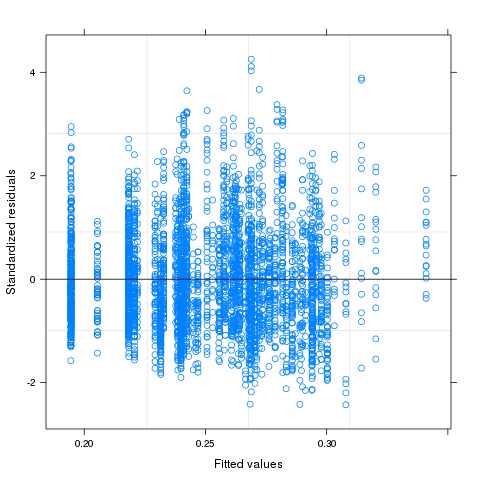

In [92]:
%%R
plot(fit5)

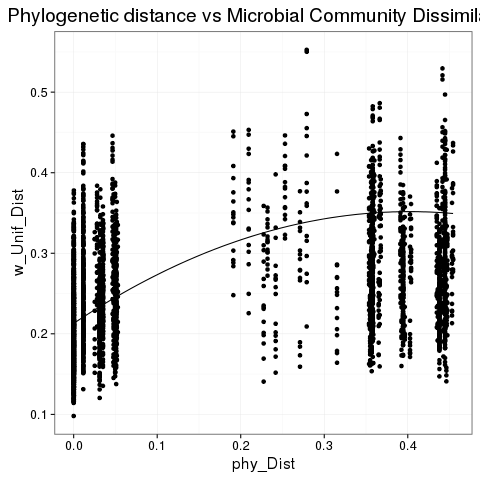

In [390]:
%%R
test <- function(x) {-.858*x ^ 2 + .69*x + .213}

               
p = ggplot(Dist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point() #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .204, se = FALSE)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("Phylogenetic distance vs Microbial Community Dissimilarity ")
#p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
p = p + stat_function(fun = test)
p

### Not used, but if date/combo is random effect:

In [ ]:
%%R
Dist$DateCombo = ifelse(as.numeric(as.character(Dist$DAY_A)) < as.numeric(as.character(Dist$DAY_B)),
                                                                    paste(Dist$DAY_A, Dist$DAY_B, sep = "-"), 
                                                                   paste(Dist$DAY_B, Dist$DAY_A, sep = "-"))
Dist$DateCombo %>% unique


In [ ]:
%%R


fit10 <- lme(w_Unif_Dist ~ 1, random =~ 1|DateCombo, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
summary(fit10) %>% print


In [ ]:
%%R
fit11 <- lme(w_Unif_Dist ~ phy_Dist, random =~ 1|DateCombo, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)

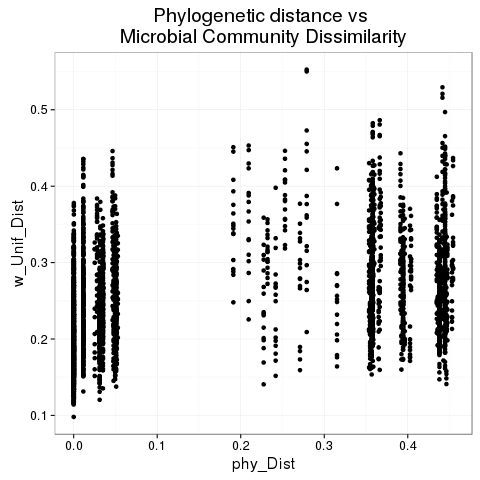

In [256]:
%%R
#test <- function(x) {-.69*x ^ 2 + .858*x + .213}

                  
p = ggplot(Dist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~poly(x,2), se = FALSE)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("Phylogenetic distance vs \n Microbial Community Dissimilarity ")
#p = p + stat_function(fun = test)
p

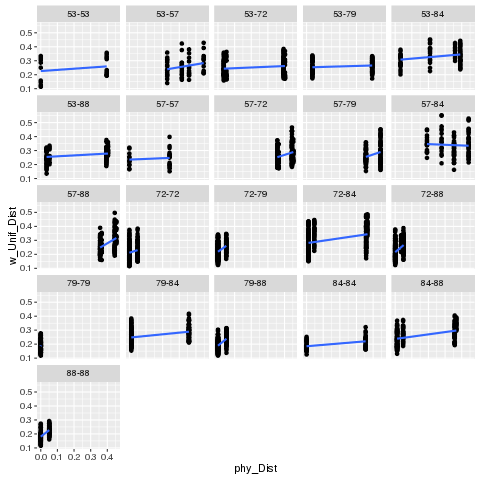

In [123]:
%%R

p = ggplot(Dist, aes(x = phy_Dist, y = w_Unif_Dist))
           p = p + geom_point()
        p = p + stat_smooth(method = "lm", se = FALSE)
           p = p + facet_wrap(~DateCombo)
           p

# GLS model on early subset of plants

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.5581 1.1550 0.48701 0.02980
Proportion of Variance 0.6069 0.3335 0.05929 0.00022
Cumulative Proportion  0.6069 0.9405 0.99978 1.00000
                        PC1         PC2       PC3        PC4
log(SeedSize_mg)  0.5335000 -0.35762792 0.7637714  0.0642903
A_Resid_logN     -0.5518070 -0.42993478 0.2407640 -0.6728282
A_Resid_logCN    -0.1202952  0.82476307 0.4914675 -0.2524967
A_Resid_logB     -0.6296157 -0.08381067 0.3422653  0.6923975


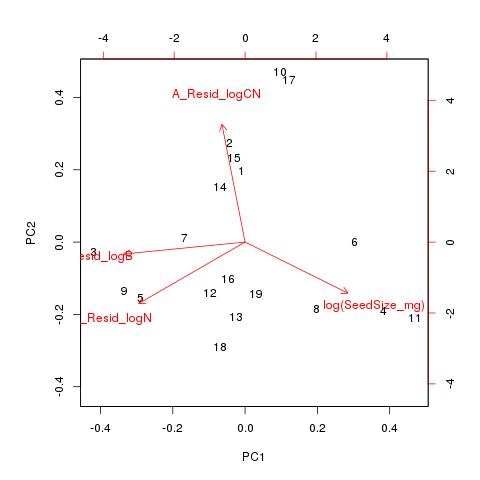

In [420]:
%%R
# PCA of annuals
phy = physeq.Nneg #start from raw object

sd = as(sample_data(phy), "data.frame")

sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")

data = filter(sd, DAP %in% c( "53", "57", "61"))
data$Plant %>% levels %>% print

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = data, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)
 

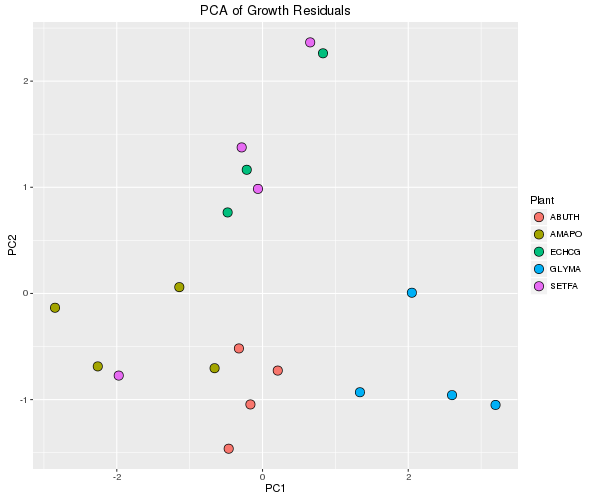

In [421]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(data[,1:57], S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, fill = Plant))
p = p + geom_point(pch = 21, size = 4)
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [422]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB    PC3Dist
1 sample4-2.02_Nneg sample4-2.02_Nneg 0.00000000
2 sample4-4.21_Nneg sample4-2.02_Nneg 0.33812225
3 sample2-2.08_Nneg sample4-2.02_Nneg 0.61787646
4 sample3-2.03_Nneg sample4-2.02_Nneg 0.03565969
5 sample4-1.03_Nneg sample4-2.02_Nneg 0.51134978
6 sample3-3.06_Nneg sample4-2.02_Nneg 0.86741853
                             PlotComp
1 sample4-2.02_Nneg-sample4-2.02_Nneg
2 sample4-4.21_Nneg-sample4-2.02_Nneg
3 sample2-2.08_Nneg-sample4-2.02_Nneg
4 sample3-2.03_Nneg-sample4-2.02_Nneg
5 sample4-1.03_Nneg-sample4-2.02_Nneg
6 sample3-3.06_Nneg-sample4-2.02_Nneg
              PlotA             PlotB     CNdist
1 sample4-2.02_Nneg sample4-2.02_Nneg 0.00000000
2 sample4-4.21_Nneg sample4-2.02_Nneg 0.09187120
3 sample2-2.08_Nneg sample4-2.02_Nneg 0.05342428
4 sample3-2.03_Nneg sample4-2.02_Nneg 0.34226220
5 sample4-1.03_Nneg sample4-2.02_Nneg 0.17376359
6 sample3-3.06_Nneg sample4-2.02_Nneg 0.11708672
                             PlotComp
1 sample4-

In [423]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "53", "57", "61") & DAY_B %in% c( "53", "57", "61"))


dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   21
[1] 171  21
[1] SETFA AMAPO GLYMA ABUTH ECHCG
Levels: ABUTH AMAPO ECHCG GLYMA SETFA


In [424]:
%%R
colnames(SubDist) %>% print
PCA.m %>% colnames %>% print

 [1] "PlotA"       "PlotB"       "w_Unif_Dist" "PlantA"      "PlantB"     
 [6] "PlantComp"   "PlotComp"    "phy_Dist"    "LibraryA"    "DAY_A"      
[11] "LibraryB"    "DAY_B"       "PC1Dist"     "PC2Dist"     "PC3Dist"    
[16] "FunDist"     "CNdist"      "Bdist"       "TimeDist"    "LibraryComp"
[21] "SameDay"    
[1] "PlotA"    "PlotB"    "PC1Dist"  "PlotComp" "PC2Dist"  "PC3Dist"  "FunDist" 
[8] "CNdist"   "Bdist"   


In [425]:
%%R
SubDist = left_join(SubDist[,c(1:12,19:21)], PCA.m[,3:9], by = "PlotComp")
tail(SubDist) %>% print


                PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
166 sample3-4.18_Nneg sample3-3.30_Nneg   0.2286788  ABUTH  ABUTH ABUTH-ABUTH
167 sample2-2.10_Nneg sample3-3.30_Nneg   0.3542649  ECHCG  ABUTH ECHCG-ABUTH
168 sample2-3.20_Nneg sample3-3.30_Nneg   0.1637463  ECHCG  ABUTH ECHCG-ABUTH
169 sample3-1.20_Nneg sample3-3.30_Nneg   0.2223193  ABUTH  ABUTH ABUTH-ABUTH
170 sample2-1.24_Nneg sample3-3.30_Nneg   0.2134040  ECHCG  ABUTH ECHCG-ABUTH
171 sample3-2.19_Nneg sample3-3.30_Nneg   0.1662544  ABUTH  ABUTH ABUTH-ABUTH
                               PlotComp phy_Dist LibraryA DAY_A LibraryB DAY_B
166 sample3-4.18_Nneg-sample3-3.30_Nneg  0.00000        2    57        2    57
167 sample2-2.10_Nneg-sample3-3.30_Nneg  0.35879        2    53        2    57
168 sample2-3.20_Nneg-sample3-3.30_Nneg  0.35879        2    53        2    57
169 sample3-1.20_Nneg-sample3-3.30_Nneg  0.00000        2    57        2    57
170 sample2-1.24_Nneg-sample3-3.30_Nneg  0.35879        2  

In [426]:
%%R
SubDist$DAY_A %>% unique

[1] 61 53 57
Levels: 53 57 61


In [427]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [428]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -572.9469 -563.5395 289.4734

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3437059 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2442186 0.01806515 13.51877       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9596585 -0.6918894 -0.1685355  0.7146741  2.7786870 

Residual standard error: 0.06632499 
Degrees of freedom: 171 total; 170 residual


In [433]:
%%R
fit2=  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay 
  Data: SubDist 
        AIC       BIC   logLik
  -578.4524 -565.9328 293.2262

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3583939 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.22766022 0.018828099 12.091513   0e+00
SameDay1    0.02440937 0.005966594  4.091005   1e-04

 Correlation: 
         (Intr)
SameDay1 -0.215

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7127356 -0.7151168 -0.1873108  0.6716921  2.6645671 

Residual standard error: 0.06621917 
Degrees of freedom: 171 total; 169 residual


In [435]:
%%R
fit3=  gls(w_Unif_Dist ~ SameDay + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -581.8775 -566.2577 295.9388

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3628187 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21763188 0.018820106 11.563797  0.0000
SameDay1    0.01226746 0.006772043  1.811485  0.0719
phy_Dist    0.06743478 0.019637176  3.434037  0.0007

 Correlation: 
         (Intr) SamDy1
SameDay1 -0.096       
phy_Dist -0.155 -0.523

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6061678 -0.7523369 -0.1661927  0.6663387  2.6465692 

Residual standard error: 0.06508475 
Degrees of freedom: 171 total; 168 residual


In [438]:
%%R
fit4=  gls(w_Unif_Dist ~   SameDay  + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + poly(phy_Dist, 2) 
  Data: SubDist 
        AIC       BIC   logLik
  -577.5192 -558.8113 294.7596

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3631226 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)        0.23522773 0.01881830 12.499947  0.0000
SameDay1           0.01325381 0.00691106  1.917769  0.0568
poly(phy_Dist, 2)1 0.13798554 0.04058196  3.400170  0.0008
poly(phy_Dist, 2)2 0.03339920 0.04538935  0.735838  0.4629

 Correlation: 
                   (Intr) SamDy1 p(_D,2)1
SameDay1           -0.249                
poly(phy_Dist, 2)1  0.130 -0.520         
poly(phy_Dist, 2)2 -0.048  0.194 -0.037  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6123310 -0.7762844 -0.1505322  0.6749722  2.6734668 

Residual standard error: 0.06523585 
Degrees of freedom: 171 total; 167 residual


In [443]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ SameDay +  PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -548.1808 -526.3969 281.0904

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3609218 

Coefficients:
                 Value   Std.Error   t-value p-value
(Intercept) 0.21870112 0.020964027 10.432210  0.0000
SameDay1    0.02163216 0.006314605  3.425734  0.0008
PC1Dist     0.00353764 0.003172665  1.115036  0.2664
PC2Dist     0.00327086 0.003662883  0.892973  0.3732
PC3Dist     0.00067957 0.010953650  0.062040  0.9506

 Correlation: 
         (Intr) SamDy1 PC1Dst PC2Dst
SameDay1 -0.081                     
PC1Dist  -0.246 -0.206              
PC2Dist  -0.197 -0.254  0.031       
PC3Dist  -0.295 -0.039  0.048  0.050

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6839937 -0.7294376 -0.1634110  0.7385262  2.5638398 

Residual standard error: 0.06693602 
Degrees 

In [445]:
%%R
fit6=  gls(w_Unif_Dist ~SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC      BIC   logLik
  -550.8366 -525.989 283.4183

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3577294 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.22083065 0.020179593 10.943266  0.0000
SameDay1     0.01190287 0.006842225  1.739621  0.0838
phy_Dist     0.07862309 0.024230233  3.244834  0.0014
PC1Dist      0.00017759 0.003256979  0.054526  0.9566
PC2Dist     -0.00404259 0.004213384 -0.959465  0.3387
PC3Dist     -0.00199264 0.010684047 -0.186506  0.8523

 Correlation: 
         (Intr) SamDy1 phy_Ds PC1Dst PC2Dst
SameDay1 -0.088                            
phy_Dist  0.031 -0.438                     
PC1Dist  -0.245 -0.036 -0.318              
PC2Dist  -0.185  0.040 -0.533  0.195       
PC3Dist  -0.299 -0.002 -0.075  0.069  0.083

Standardized residuals:
       Min

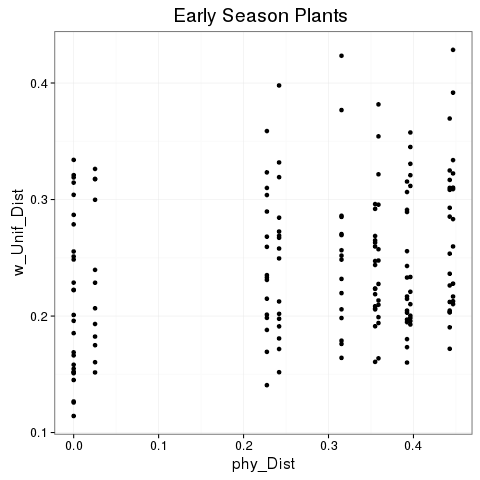

In [251]:
%%R
p1 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p1 = p1 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p1 = p1 + theme_bw(base_size = 16)
p1 = p1 + ggtitle("Early Season Plants ")
#p = p + stat_function(fun = test)
p1

# Subset of late season plants

[1] "B73"    "ELCOR"  "ERATE"  "HELAN"  "SORBI"  "SORSUD"
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.4973 1.1837 0.59627 0.03612
Proportion of Variance 0.5605 0.3503 0.08888 0.00033
Cumulative Proportion  0.5605 0.9108 0.99967 1.00000
                        PC1         PC2        PC3         PC4
log(SeedSize_mg) -0.5549666  0.24710822 -0.7936365 -0.03302717
A_Resid_logN     -0.4687695 -0.59539147  0.1686459 -0.63033538
A_Resid_logCN    -0.2340853  0.76240075  0.4191288 -0.43391266
A_Resid_logB     -0.6461202 -0.05649449  0.4074687  0.64288904


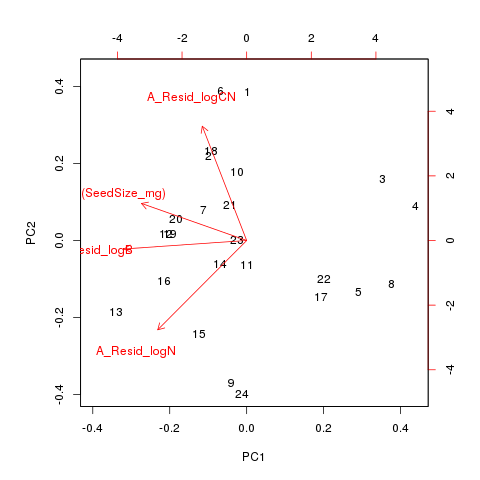

In [372]:
%%R
# PCA of annuals
sd = as(sample_data(phy), "data.frame")

# sd = left_join(sd, SS, by = "Plant")
# sd = left_join(sd, M_GDD, by = "DAP")

data = filter(sd, Plant %in% c("B73", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN")) 
data$Plant %>% levels %>% print

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = data, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)
 

In [371]:
%%R -w 600 -h 500
colnames(data) # find numbers to drop

 [1] "PlotA"       "PlotB"       "w_Unif_Dist" "PlantA"      "PlantB"     
 [6] "PlantComp"   "PlotComp"    "phy_Dist"    "LibraryA"    "DAY_A"      
[11] "LibraryB"    "DAY_B"       "TimeDist"    "LibraryComp" "SameDay"    
[16] "PC1Dist"     "PC2Dist"     "PC3Dist"     "FunDist"     "CNdist"     
[21] "Bdist"      


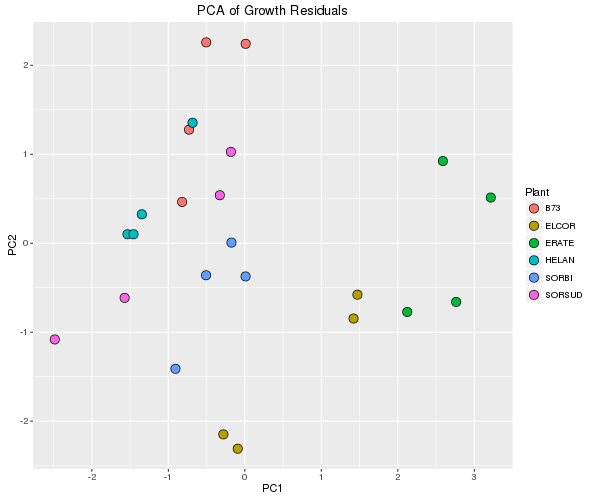

In [376]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(data[,1:57], S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, fill = Plant))
p = p + geom_point(pch = 21, size = 4)
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [335]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB   PC3Dist
1 sample6-2.26_Nneg sample6-2.26_Nneg 0.0000000
2 sample6-3.18_Nneg sample6-2.26_Nneg 0.2178990
3 sample5-3.11_Nneg sample6-2.26_Nneg 1.6020730
4 sample5-4.06_Nneg sample6-2.26_Nneg 1.0377879
5 sample5-2.18_Nneg sample6-2.26_Nneg 1.4008179
6 sample6-4.30_Nneg sample6-2.26_Nneg 0.3642588
                             PlotComp
1 sample6-2.26_Nneg-sample6-2.26_Nneg
2 sample6-3.18_Nneg-sample6-2.26_Nneg
3 sample5-3.11_Nneg-sample6-2.26_Nneg
4 sample5-4.06_Nneg-sample6-2.26_Nneg
5 sample5-2.18_Nneg-sample6-2.26_Nneg
6 sample6-4.30_Nneg-sample6-2.26_Nneg
              PlotA             PlotB     CNdist
1 sample6-2.26_Nneg sample6-2.26_Nneg 0.00000000
2 sample6-3.18_Nneg sample6-2.26_Nneg 0.15821962
3 sample5-3.11_Nneg sample6-2.26_Nneg 0.32359357
4 sample5-4.06_Nneg sample6-2.26_Nneg 0.55719490
5 sample5-2.18_Nneg sample6-2.26_Nneg 0.75189285
6 sample6-4.30_Nneg sample6-2.26_Nneg 0.09339611
                             PlotComp
1 sample6-2.26_Nn

In [347]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, PlantA %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") & PlantB %in% c("B73", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI",  "HELAN"))
dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   21
[1] 276  21
[1] B73    ERATE  ELCOR  SORSUD SORBI  HELAN 
Levels: B73 ELCOR ERATE HELAN SORBI SORSUD


In [351]:
%%R
colnames(SubDist)
PCA.m %>% colnames
SubDist = left_join(SubDist[,c(1:12,19:21)], PCA.m[,3:9], by = "PlotComp")
tail(SubDist) %>% print


                PlotA             PlotB w_Unif_Dist PlantA PlantB    PlantComp
271 sample7-3.12_Nneg sample8-3.03_Nneg   0.3062711  HELAN  ELCOR  HELAN-ELCOR
272 sample7-4.03_Nneg sample8-3.03_Nneg   0.3777692  HELAN  ELCOR  HELAN-ELCOR
273 sample7-1.28_Nneg sample8-3.03_Nneg   0.3428638  HELAN  ELCOR  HELAN-ELCOR
274 sample7-3.25_Nneg sample8-3.03_Nneg   0.2164129 SORSUD  ELCOR SORSUD-ELCOR
275 sample8-4.01_Nneg sample8-3.03_Nneg   0.2115333  ELCOR  ELCOR  ELCOR-ELCOR
276 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR  SORBI-ELCOR
                               PlotComp phy_Dist LibraryA DAY_A LibraryB DAY_B
271 sample7-3.12_Nneg-sample8-3.03_Nneg  0.36765        2    84        2    88
272 sample7-4.03_Nneg-sample8-3.03_Nneg  0.36765        2    84        2    88
273 sample7-1.28_Nneg-sample8-3.03_Nneg  0.36765        2    84        2    88
274 sample7-3.25_Nneg-sample8-3.03_Nneg  0.04779        2    84        2    88
275 sample8-4.01_Nneg-sample8-3.03_Nneg  0.00000    

In [352]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [353]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -665.0201 -654.1698 335.5101

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1307399 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.2681774 0.01204274 22.26881       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9814712 -0.6841784 -0.1141655  0.6066197  2.8341968 

Residual standard error: 0.07699199 
Degrees of freedom: 276 total; 275 residual


In [354]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -869.3277 -847.6928 440.6638

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2552378 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.17954369 0.013293440 13.506187  0.0000
TimeDist     0.00323169 0.001433143  2.254964  0.0249
SameDay1     0.09952131 0.009430748 10.552854  0.0000
LibraryComp1 0.00345826 0.009890229  0.349664  0.7269

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.078              
SameDay1     -0.183 -0.548       
LibraryComp1  0.055 -0.710  0.043

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.05951849 -0.63649379 -0.05109346  0.70998688  2.78267265 

Residual standard error: 0.05932584 
Degrees of freedom: 276 total; 272 residual


In [355]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -900.3415 -875.1266 457.1707

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2146269 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.16541040 0.011193372 14.777530  0.0000
TimeDist     0.00364662 0.001324804  2.752573  0.0063
SameDay1     0.08802806 0.008988500  9.793408  0.0000
LibraryComp1 0.00329250 0.009222075  0.357024  0.7214
phy_Dist     0.15981098 0.024533008  6.514121  0.0000

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist     -0.089                     
SameDay1     -0.169 -0.544              
LibraryComp1  0.057 -0.702  0.031       
phy_Dist     -0.202  0.033 -0.171  0.006

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.24750636 -0.65451700 -0.08562476  0.56041635  2.65969617 

Res

In [356]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
       AIC       BIC  logLik
  -906.264 -877.4766 461.132

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2156526 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.1755202 0.01127249 15.570669  0.0000
TimeDist            0.0054957 0.00142737  3.850244  0.0001
SameDay1            0.0967115 0.00924638 10.459396  0.0000
LibraryComp1       -0.0105369 0.01005832 -1.047580  0.2958
poly(phy_Dist, 2)1  0.4405850 0.06199458  7.106830  0.0000
poly(phy_Dist, 2)2  0.1781098 0.05588840  3.186883  0.0016

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist           -0.182                              
SameDay1           -0.282 -0.355                       
LibraryComp1        0.169 -0.755 -0.100                
poly(phy_Dist, 2)1  0.016  0.108 

In [378]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp  + PC1Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist 
  Data: SubDist 
        AIC      BIC   logLik
  -901.8768 -876.662 457.9384

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2304395 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.16482928 0.011583751 14.229353  0.0000
TimeDist     -0.00152142 0.001488343 -1.022227  0.3076
SameDay1      0.08788913 0.008881266  9.896014  0.0000
LibraryComp1  0.03184962 0.010023614  3.177459  0.0017
PC1Dist       0.02165622 0.003116164  6.949642  0.0000

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.016                     
SameDay1     -0.161 -0.395              
LibraryComp1 -0.025 -0.761 -0.039       
PC1Dist      -0.187 -0.467 -0.175  0.412

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.29992148 -0.61306651 -0.05617992  0.68437925  2.76111936 



In [379]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2)  + PC1Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + PC1Dist 
  Data: SubDist 
       AIC       BIC  logLik
  -930.648 -898.2956 474.324

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1889258 

Coefficients:
                       Value  Std.Error   t-value p-value
(Intercept)        0.1632054 0.01001765 16.291794  0.0000
TimeDist           0.0011996 0.00150123  0.799092  0.4249
SameDay1           0.0876705 0.00879333  9.970115  0.0000
LibraryComp1       0.0149003 0.01027685  1.449887  0.1483
poly(phy_Dist, 2)1 0.3762567 0.05832567  6.450962  0.0000
poly(phy_Dist, 2)2 0.1581972 0.05278775  2.996854  0.0030
PC1Dist            0.0184219 0.00294736  6.250308  0.0000

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1 p(_D,2)2
TimeDist           -0.073                                       
SameDay1           -0.268 -0.237                                
L

In [380]:
%%R
fit7=  gls(w_Unif_Dist ~  SameDay + poly(phy_Dist,2)  + PC1Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit7)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + poly(phy_Dist, 2) + PC1Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -941.8657 -916.6509 477.9329

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1845845 

Coefficients:
                       Value  Std.Error   t-value p-value
(Intercept)        0.1625334 0.01006010 16.156240   0e+00
SameDay1           0.1064977 0.00704358 15.119819   0e+00
poly(phy_Dist, 2)1 0.3678224 0.05831297  6.307729   0e+00
poly(phy_Dist, 2)2 0.1749187 0.04864644  3.595714   4e-04
PC1Dist            0.0190821 0.00264285  7.220260   0e+00

 Correlation: 
                   (Intr) SamDy1 p(_D,2)1 p(_D,2)2
SameDay1           -0.342                         
poly(phy_Dist, 2)1  0.065 -0.034                  
poly(phy_Dist, 2)2 -0.272  0.412  0.139           
PC1Dist            -0.272 -0.334 -0.111    0.163  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2

In [360]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fit1     1  3 -665.0201 -654.1698 335.5101                         
fit2     2  6 -869.3277 -847.6928 440.6638 1 vs 2 210.30754  <.0001
fit3     3  7 -900.3415 -875.1266 457.1707 2 vs 3  33.01381  <.0001
fit4     4  8 -906.2640 -877.4766 461.1320 3 vs 4   7.92251  0.0049
fit5     5  9 -881.3531 -849.0007 449.6766 4 vs 5  22.91086  <.0001
fit6     6  9 -930.6480 -898.2956 474.3240                         


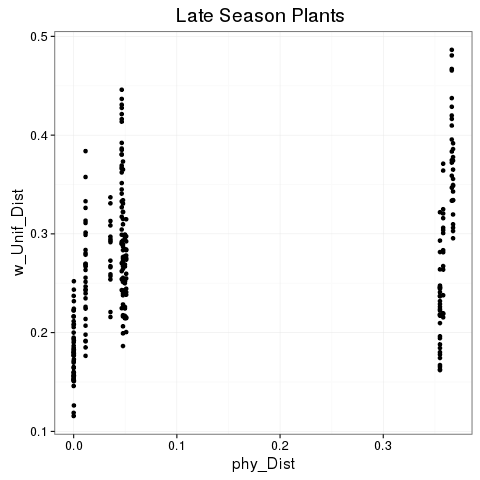

In [385]:
%%R
p2 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p2 = p2 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p2 = p2 + theme_bw(base_size = 16)
p2 = p2 + ggtitle("Late Season Plants ")
#p = p + stat_function(fun = test)
p2

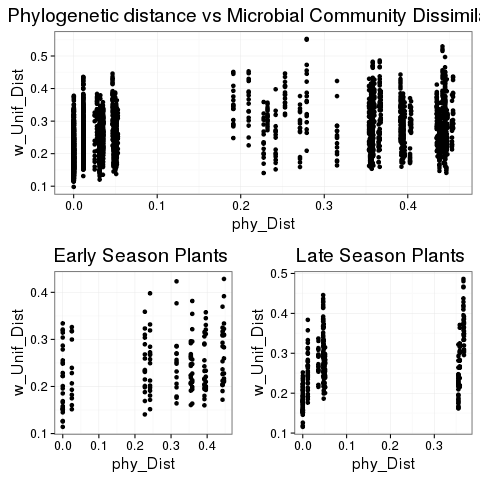

In [388]:
%%R
 grid.arrange(p,p1,p2, layout_matrix = rbind(c(1, 1), c(2,3)))

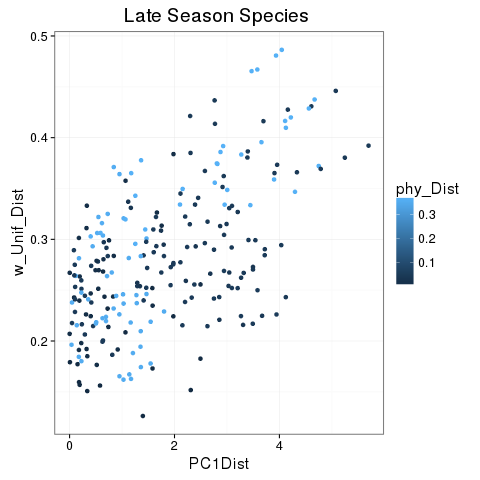

In [368]:
%%R
data = filter(SubDist, PlantA != PlantB)
p3 = ggplot(data, aes(y = w_Unif_Dist, x = PC1Dist, color = phy_Dist) )
p3 = p3 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p3 = p3 + theme_bw(base_size = 16)
p3 = p3 + ggtitle("Late Season Species ")
#p = p + stat_function(fun = test)
p3

### PCA showing just late season annuals and B73

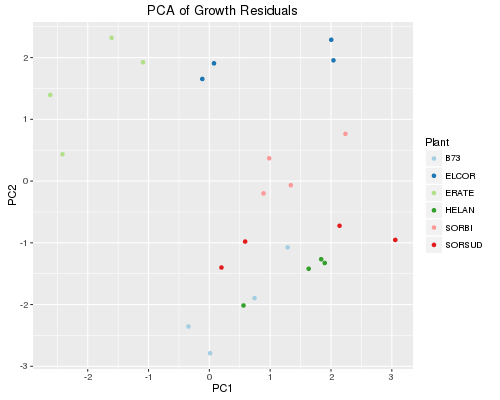

In [318]:
%%R -w 500 -h 400
data = filter(E_Fit, Plant %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") )
p = ggplot(data, aes(PC1, PC2, colour = Plant), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

# Subset of late season plants with all maize

## recreate functional distance variables on subset

In [261]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "72", "79", "84", "88") & DAY_B %in% c( "72", "79", "84", "88"))

dim(SubDist) %>% print
SubDist$PlantA %>% unique


[1] 3741   21
[1] 2016   21
 [1] 75-062 MS71   B73    Oh7B   B97    H99    Il14H  ERATE  ELCOR  SORSUD
[11] Ki3    SORBI  Hp301  HELAN  Tx303  Mo18  
16 Levels: 75-062 B73 B97 ELCOR ERATE H99 HELAN Hp301 Il14H Ki3 Mo18 ... Tx303


In [262]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [263]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: SubDist 
        AIC       BIC   logLik
  -6409.249 -6392.424 3207.625

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.251618 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2350195 0.008348303 28.15177       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8075544 -0.7440251 -0.1621121  0.5931403  3.8053914 

Residual standard error: 0.06605584 
Degrees of freedom: 2016 total; 2015 residual


In [264]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -6681.806 -6648.165 3346.903

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2710062 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20345771 0.008506148 23.918900   0e+00
TimeDist     -0.00146817 0.000428982 -3.422450   6e-04
SameDay1      0.04373292 0.004098648 10.670084   0e+00
LibraryComp1  0.01768391 0.002891179  6.116504   0e+00

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist      0.041              
SameDay1     -0.134 -0.782       
LibraryComp1 -0.044 -0.658  0.292

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0889256 -0.7463494 -0.1253755  0.5947027  3.7627957 

Residual standard error: 0.06355152 
Degrees of freedom: 2016 total; 2012 residual


In [265]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -6778.996 -6739.751 3396.498

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2425501 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.19336502 0.007535196 25.661578  0.0000
TimeDist     -0.00091187 0.000421620 -2.162777  0.0307
SameDay1      0.03628378 0.004061779  8.932977  0.0000
LibraryComp1  0.01521089 0.002833924  5.367432  0.0000
phy_Dist      0.23521826 0.022492658 10.457557  0.0000

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.028                     
SameDay1     -0.124 -0.785              
LibraryComp1 -0.037 -0.660  0.299       
phy_Dist     -0.128  0.124 -0.174 -0.082

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.5026553 -0.7282384 -0.1196183  0.6027257  3.4317787 

Residua

In [266]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
        AIC      BIC   logLik
  -6782.227 -6737.38 3399.114

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2345679 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2067427 0.00726010 28.476569  0.0000
TimeDist           -0.0008803 0.00042137 -2.089043  0.0368
SameDay1            0.0356805 0.00406570  8.775987  0.0000
LibraryComp1        0.0149753 0.00283420  5.283792  0.0000
poly(phy_Dist, 2)1  1.1519411 0.11496983 10.019508  0.0000
poly(phy_Dist, 2)2 -0.1799512 0.07759734 -2.319038  0.0205

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist            0.051                              
SameDay1           -0.159 -0.785                       
LibraryComp1       -0.054 -0.660  0.300                
poly(phy_Dist, 2)1  0.035  0.11

In [267]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp  + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)



Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC2Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -6670.959 -6631.714 3342.479

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2701235 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20125779 0.008585233 23.442322  0.0000
TimeDist     -0.00140737 0.000430484 -3.269268  0.0011
SameDay1      0.04258019 0.004159509 10.236830  0.0000
LibraryComp1  0.01738842 0.002896085  6.004112  0.0000
PC2Dist       0.00211841 0.001319284  1.605730  0.1085

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist      0.026                     
SameDay1     -0.104 -0.783              
LibraryComp1 -0.033 -0.660  0.298       
PC2Dist      -0.160  0.088 -0.172 -0.063

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0700325 -0.7397505 -0.1186156  0.5945767  3.7603069 

Residual

In [268]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2)  + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + PC2Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -6768.807 -6718.359 3393.404

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2345896 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2065111 0.00739707 27.917941  0.0000
TimeDist           -0.0008755 0.00042248 -2.072178  0.0384
SameDay1            0.0355831 0.00410961  8.658508  0.0000
LibraryComp1        0.0149521 0.00283838  5.267844  0.0000
poly(phy_Dist, 2)1  1.1499523 0.11563366  9.944789  0.0000
poly(phy_Dist, 2)2 -0.1785691 0.07806171 -2.287538  0.0223
PC2Dist             0.0002149 0.00130386  0.164801  0.8691

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1 p(_D,2)2
TimeDist            0.037                                       
SameDay1           -0.127 -0.784                      